# Assignment 1
### Maurits van Altvorst and Philipp Höcker

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from scipy.stats import jarque_bera
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import warnings

sns.set_style("whitegrid")


### 1. 
#### (1 point)
Import the time series and plot the data. Is a deterministic trend present in the data

In [15]:
# Import the CSV file into a pandas dataframe
def read_df(filename: str) -> pd.DataFrame:
    df = pd.read_csv(filename)
    df["DATE"] = pd.to_datetime(df["DATE"])
    return df.set_index("DATE")

df = read_df("RGPDIC.csv")
df_no_sa = read_df("RGPDICnoSA.csv")
df_merged = pd.concat([df, df_no_sa], axis=1)
df_merged

,DI,DIS
DATE,,
1947-01-01,218.091,NaN
1947-04-01,201.386,NaN
1947-07-01,195.461,NaN
1947-10-01,233.284,NaN
1948-01-01,257.220,NaN
...,...,...
2022-01-01,3892.480,935.515
2022-04-01,3746.973,930.582
2022-07-01,3653.850,950.800


<Axes: xlabel='DATE', ylabel='DI'>

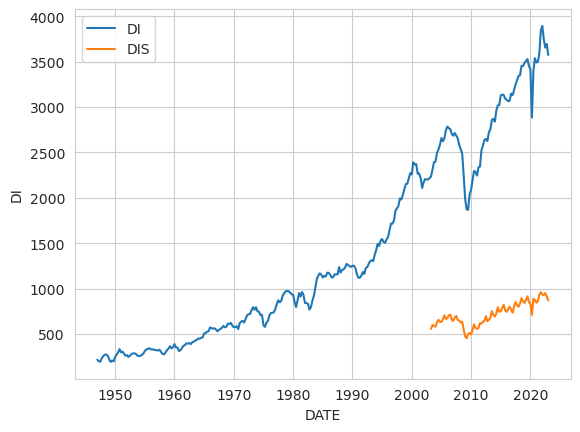

In [18]:
sns.lineplot(data = df, x = df.index, y = "DI", label = "DI")
sns.lineplot(data = df_no_sa, x = df_no_sa.index, y = "DIS", label = "DIS")

In [21]:
df["DI"]

DATE
1947-01-01     218.091
1947-04-01     201.386
1947-07-01     195.461
1947-10-01     233.284
1948-01-01     257.220
                ...   
2022-01-01    3892.480
2022-04-01    3746.973
2022-07-01    3653.850
2022-10-01    3694.128
2023-01-01    3573.078
Name: DI, Length: 305, dtype: float64

                            OLS Regression Results                            
Dep. Variable:                     DI   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     3115.
Date:                Tue, 16 May 2023   Prob (F-statistic):          1.78e-161
Time:                        11:17:54   Log-Likelihood:                -2183.2
No. Observations:                 305   AIC:                             4370.
Df Residuals:                     303   BIC:                             4378.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -326.3872     35.791     -9.119      0.0

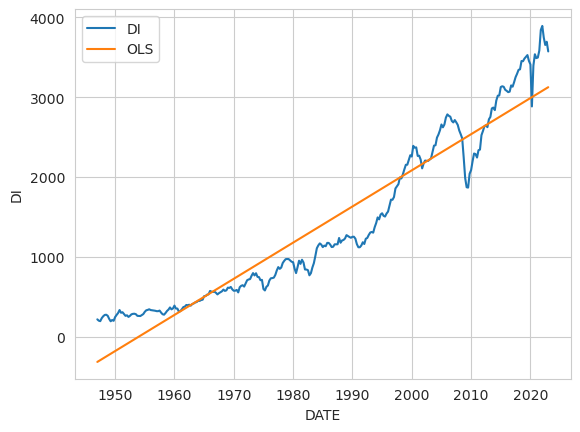

In [30]:
def q1_plot_deterministic_trend(df: pd.DataFrame, target: str):
    df = df.copy()
    df["t"] = np.arange(len(df)) + 1
    sns.lineplot(data = df, x = df.index, y = target, label = target)
    reg = sm.OLS(df[target], sm.add_constant(df["t"])).fit()
    sns.lineplot(data = df, x = df.index, y = reg.predict(sm.add_constant(df["t"])), label = "OLS")
    print(reg.summary())

q1_plot_deterministic_trend(df, "DI")

                            OLS Regression Results                            
Dep. Variable:                    DIS   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     155.8
Date:                Tue, 16 May 2023   Prob (F-statistic):           2.81e-20
Time:                        11:26:00   Log-Likelihood:                -456.31
No. Observations:                  80   AIC:                             916.6
Df Residuals:                      78   BIC:                             921.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        539.4815     16.596     32.506      0.0

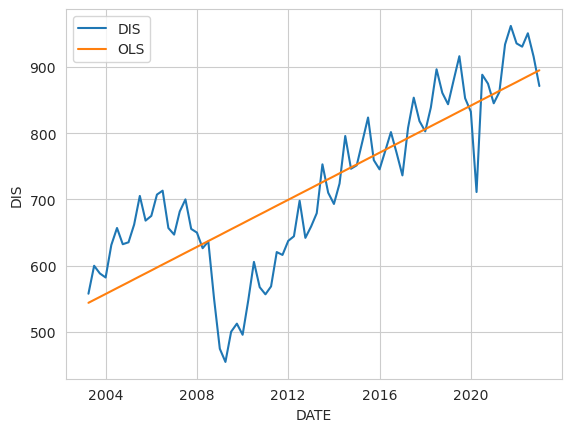

In [38]:
# THIS ONE IS UNNECESSARY, ONLY FOR LATER Q'S.
q1_plot_deterministic_trend(df_no_sa, "DIS")

### 2. 
#### (2 point)
Apply the Augmented Dickey-Fuller (ADF) test to examine the presence of a unit root in yt.
Include in the test equation an intercept term and select the number of included lags based on AIC. Is a
stochastic trend present in the data?

$H_0$: There is a unit root in the time series

$H_A$: There is no unit root in the time series

In [37]:
from statsmodels.tsa.stattools import adfuller

# Apply the Augmented Dickey-Fuller (ADF) test to examine the presence of a unit root in yt.
#Include in the test equation an intercept term and select the number of included lags based on AIC. Is a
#stochastic trend present in the data?

def q2_adf(df: pd.DataFrame, target: str, maxlag: int = None):
    # Copy the DataFrame to avoid modifying original data
    df = df.copy()

    # Perform ADF test
    result = adfuller(df[target], maxlag=maxlag, autolag='AIC', regression='c')

    # Print out results
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    # If the ADF statistic is less than the critical value, we reject the null hypothesis
    # (i.e., we assume the time series is stationary).
    if result[0] < result[4]["5%"]:
        print("The series is stationary")
    else:
        print("The series is non-stationary")

q2_adf(df, "DI")


ADF Statistic: 0.811844
p-value: 0.991825
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
The series is non-stationary


### 3. 
#### (2 point)
Apply the ADF test to examine the presence of a unit root in yt including additionally a
deterministic trend in the test equation. Compare the test results to the results obtained in (2.). Given the
properties of the time series, which specification of the test regression is preferable (which deterministic
components do you include in the test regression)?

$H_0$: There is a unit root in the time series

$H_A$: There is no unit root in the time series

In [39]:
# Apply the ADF test to examine the presence of a unit root in yt including additionally a
# deterministic trend in the test equation. Compare the test results to the results obtained in (2.). Given the
# properties of the time series, which specification of the test regression is preferable (which deterministic
# components do you include in the test regression)?

def q3_adf_trend(df: pd.DataFrame, target: str, maxlag: int = None):
    # Copy the DataFrame to avoid modifying original data
    df = df.copy()

    # Perform ADF test
    result = adfuller(df[target], maxlag=maxlag, autolag='AIC', regression='ct')

    # Print out results
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    # If the ADF statistic is less than the critical value, we reject the null hypothesis
    # (i.e., we assume the time series is stationary).
    if result[0] < result[4]["5%"]:
        print("The series is stationary")
    else:
        print("The series is non-stationary")

q3_adf_trend(df, "DI")

ADF Statistic: -1.983533
p-value: 0.610375
Critical Values:
	1%: -3.989
	5%: -3.425
	10%: -3.136
The series is non-stationary


We are closer to rejecting so I'd include a time trend.

### 4. 
#### (2 point)
Estimate AR(p) models for p = 1, . . . , 12 for yt including an intercept and deterministic trend.
Which model does the AIC indicate as the preferred choice

In [46]:
df

,DI
DATE,
1947-01-01,218.091
1947-04-01,201.386
1947-07-01,195.461
1947-10-01,233.284
1948-01-01,257.220
...,...
2022-01-01,3892.480
2022-04-01,3746.973
2022-07-01,3653.850


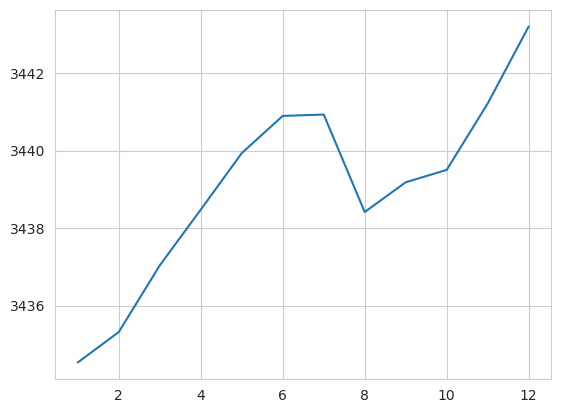

In [47]:
from statsmodels.tsa.arima.model import ARIMA

# Estimate AR(p) models for p = 1, . . . , 12 for yt including an intercept and deterministic trend.
# Which model does the AIC indicate as the preferred choice

def q4_ar_plot(df: pd.DataFrame, target: str, max_p: int = 1):
    # Copy the DataFrame to avoid modifying original data
    df = df.copy()

    aics = []

    for p in range(1, max_p + 1):
        # Fit AR(p) model
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            model = ARIMA(df[target], order=(p, 0, 0), trend="ct").fit()

        aics.append(model.aic)

    aics = pd.Series(aics, index=range(1, max_p + 1))
    sns.lineplot(data=aics)


q4_ar_plot(df, "DI", max_p=12)


We choose AR(1).

### 5. 
#### (3 point)
Estimate an AR(2) model with intercept and deterministic trend for yt. Discuss the estimation
output. What conclusions regarding stationarity can you draw from the estimated parameters?

                               SARIMAX Results                                
Dep. Variable:                     DI   No. Observations:                  305
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1712.659
Date:                Tue, 16 May 2023   AIC                           3435.318
Time:                        11:41:19   BIC                           3453.919
Sample:                    01-01-1947   HQIC                          3442.758
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -326.3806    219.515     -1.487      0.137    -756.622     103.860
x1            11.7186      1.089     10.763      0.000       9.585      13.853
ar.L1          1.0429      0.024     43.308      0.0

/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


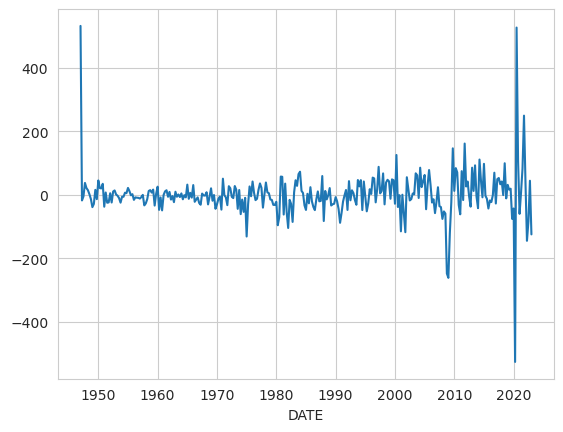

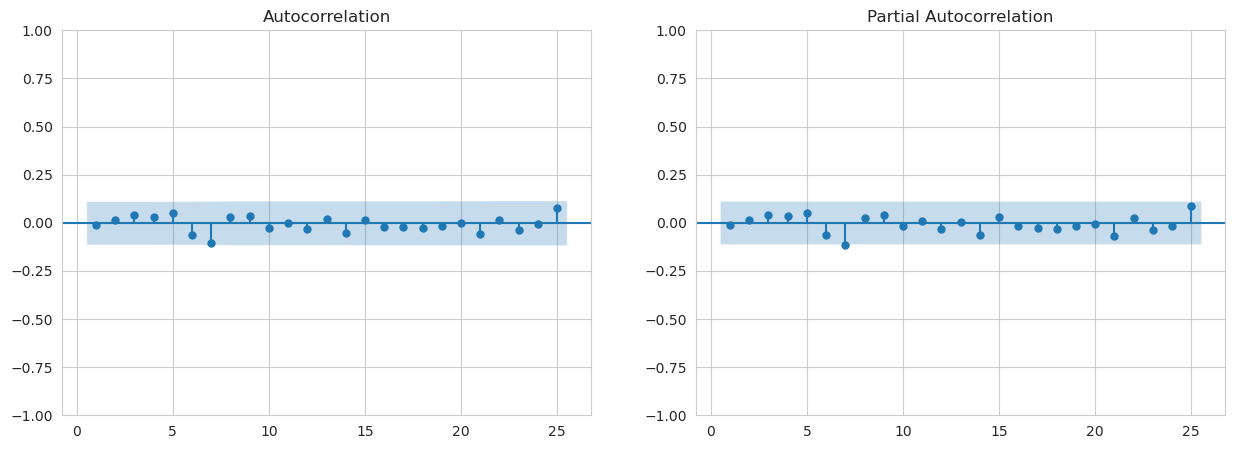

In [60]:
def q5_fit_ar2(df: pd.DataFrame, target: str):
    # Copy the DataFrame to avoid modifying original data
    df = df.copy()

    # Fit AR(2) model
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        model = ARIMA(df[target], order=(2, 0, 0), trend="ct").fit()

    # Print out results
    print(model.summary())

    # Plot residuals
    sns.lineplot(data=model.resid)

    # Plot ACF and PACF
    _, axes = plt.subplots(1, 2, figsize=(15, 5))
    plot_acf(model.resid, ax=axes[0], zero = False)
    plot_pacf(model.resid, ax=axes[1], zero = False)


q5_fit_ar2(df, "DI")

To draw a conclusion about stationarity, we need to look at the roots of the AR polynomial. The roots are 1.0429 and -0.0637.

We need to look at the characteristic polynomial of the AR(2) model: 

$\phi(z) = 1 - 1.0429z + 0.0637z^2$

The roots of this polynomial are:

    [1.02275585549394, 15.3493006594197]

The roots are outside the unit circle, so the process is stationary.

### 6. 
#### (2 point)
Evaluate the estimated AR(2) model based on the estimated residuals. Are the residuals
following a White Noise process? Test whether they are autocorrelated (using a Ljung-Box test) and also
whether they follow a normal distribution.

LB: 

$H_0$: The residuals are independently distributed

$H_A$: The residuals are not independently distributed

JB:

$H_0$: The residuals are normally distributed

$H_A$: The residuals are not normally distributed

BP:

$H_0$: The residuals are homoskedastic

$H_A$: The residuals are heteroskedastic


In [82]:
# Evaluate the estimated AR(2) model based on the estimated residuals. Are the residuals
# following a White Noise process? Test whether they are autocorrelated (using a Ljung-Box test) and also
# whether they follow a normal distribution.
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan

def q6_ar2_lb_autocorr(df: pd.DataFrame, target: str):
    # Copy the DataFrame to avoid modifying original data
    df = df.copy()

    # Fit AR(2) model
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        model = ARIMA(df[target], order=(2, 0, 0), trend="ct").fit()


    resid = model.resid
    # Perform Ljung-Box test
    ljungbox = acorr_ljungbox(resid, lags=20, return_df=True)

    # Print out results
    print(ljungbox.to_latex())

    jb = jarque_bera(resid)
    print("Jarque-Bera test statistic: {:.4f}".format(jb[0]))
    print("p-value: {:.4f}".format(jb[1]))

    # test homoskedasticity
    bp = het_breuschpagan(resid, model.model.exog)
    print("Breusch-Pagan test statistic: {:.4f}".format(bp[0]))
    print("p-value: {:.4f}".format(bp[1]))


    

q6_ar2_lb_autocorr(df, "DI")

\begin{tabular}{lrr}
\toprule
{} &   lb\_stat &  lb\_pvalue \\
\midrule
1  &  0.039255 &   0.842944 \\
2  &  0.124259 &   0.939761 \\
3  &  0.641166 &   0.886947 \\
4  &  0.960512 &   0.915723 \\
5  &  1.686319 &   0.890619 \\
6  &  2.866922 &   0.825355 \\
7  &  6.264828 &   0.509190 \\
8  &  6.505402 &   0.590808 \\
9  &  6.844115 &   0.653345 \\
10 &  7.111619 &   0.714867 \\
11 &  7.111635 &   0.789972 \\
12 &  7.487296 &   0.823805 \\
13 &  7.623011 &   0.867264 \\
14 &  8.468996 &   0.863491 \\
15 &  8.522118 &   0.901151 \\
16 &  8.699107 &   0.925286 \\
17 &  8.881618 &   0.943903 \\
18 &  9.115145 &   0.957015 \\
19 &  9.234200 &   0.969384 \\
20 &  9.236071 &   0.980008 \\
\bottomrule
\end{tabular}

Jarque-Bera test statistic: 9297.0845
p-value: 0.0000
Breusch-Pagan test statistic: 4.2956
p-value: 0.0382


/tmp/ipykernel_3617368/3988891938.py:23: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ljungbox.to_latex())


Autocorrelated. Not normal. Heteroskedasticity.

### 7. 
#### (2 point)
Take the first difference of yt. Denote the new series as ∆yt. Plot the time series and discuss
all key properties of time series data for ∆yt based on visual inspection.


<Axes: xlabel='DATE'>

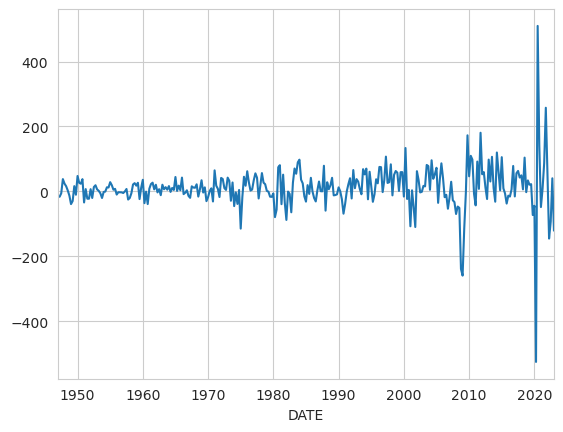

In [83]:
df["delta_DI"] = df["DI"].diff()
df["delta_DI"].plot()

### 8. 
#### (1 point)

Apply the ADF test to examine the presence of a unit root in the ∆yt. Given the properties
of the time series, which deterministic components do you include in the test regression? How do you
interpret your test results?

In [87]:
# We can re-use q2 (AIC based lag selection) to determine the number of lags to include in the ADF test

q2_adf(df.iloc[1:], "delta_DI")

ADF Statistic: -16.373476
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
The series is stationary


### 9. 
#### (1 point)

Compute a Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for the null hypothesis that yt is
level or trend stationary. Then, compute the KPSS test for the null hypothesis that ∆yt is level stationary.
How do you interpret your test results?

$H_0$: The time series is level or trend stationary

$H_A$: The time series is not level or trend stationary

In [89]:
# Compute a Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for the null hypothesis that yt is
# level or trend stationary. Then, compute the KPSS test for the null hypothesis that ∆yt is level stationary.
# How do you interpret your test results?

from statsmodels.tsa.stattools import kpss

def q7_kpss(df: pd.DataFrame, target: str, regression: str = "c"):
    # Copy the DataFrame to avoid modifying original data
    df = df.copy()

    # Perform KPSS test
    result = kpss(df[target], regression=regression)

    # Print out results
    print('KPSS Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

    # If the KPSS statistic is greater than the critical value, we reject the null hypothesis
    # (i.e., we assume the time series is stationary).
    if result[0] > result[3]["5%"]:
        print("The series is non-stationary")
    else:
        print("The series is stationary")


print("DI:")
q7_kpss(df, "DI")

print("delta_DI:")
q7_kpss(df.iloc[1:], "delta_DI")

DI:
KPSS Statistic: 2.692797
p-value: 0.010000
The series is non-stationary
delta_DI:
KPSS Statistic: 0.226907
p-value: 0.100000
The series is stationary


/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [ ]:
#TODO: fix the p-value calculation, see warning

### 10. 
#### (2 point)

The CSV file `RGPDICnoSA` contains quarterly observations on real gross private domestic
investment for the United States over the period Q2 2003 until Q1 2023 which are not seasonally adjusted.
We denote the series by $y^∗_t$.
Import the new time series and plot the data. Does this time series exhibit a seasonal pattern? Regress
$y^∗_t$ on a time trend and four seasonal dummy variables. Discuss the regression output

                            OLS Regression Results                            
Dep. Variable:                    DIS   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     42.85
Date:                Tue, 16 May 2023   Prob (F-statistic):           1.15e-18
Time:                        12:01:57   Log-Likelihood:                -452.64
No. Observations:                  80   AIC:                             915.3
Df Residuals:                      75   BIC:                             927.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
t              4.4617      0.347     12.852      0.0

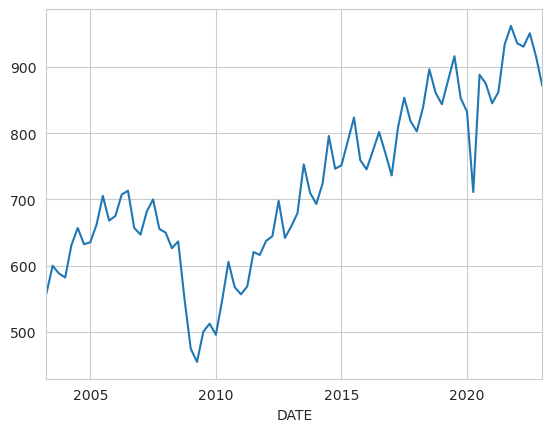

In [95]:
# The CSV file RGPDICnoSA contains quarterly observations on real gross private domestic
# investment for the United States over the period Q2 2003 until Q1 2023 which are not seasonally adjusted.
# We denote the series by y∗
# t .
# Import the new time series and plot the data. Does this time series exhibit a seasonal pattern? Regress
# y∗
# t on a time trend and four seasonal dummy variables. Discuss the regression output

def q10_regression(df: pd.DataFrame, target: str):
    df = df.copy()

    # Create time index
    df["t"] = range(1, len(df) + 1)

    # Create dummy variables
    df["Q1"] = (df.index.quarter == 1).astype(int)
    df["Q2"] = (df.index.quarter == 2).astype(int)
    df["Q3"] = (df.index.quarter == 3).astype(int)
    df["Q4"] = (df.index.quarter == 4).astype(int)

    # Fit regression model
    model = sm.OLS(df[target], df[["t", "Q1", "Q2", "Q3", "Q4"]]).fit()

    # Print out results
    print(model.summary())


df_no_sa["DIS"].plot()
q10_regression(df_no_sa, "DIS")

### 11. 
#### (2 points)

Estimate an AR(4) model including an intercept and deterministic trend for $y^∗_t$. Compute the
fitted values obtained from the AR(4) model. How accurate are the fitted values compared to the actual
data $y^∗_t$? You can answer this by inspecting a plot of the fitted values and actual data

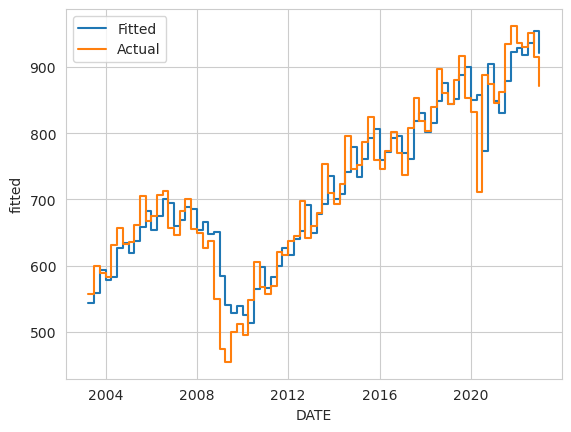

In [103]:
# Estimate an AR(4) model including an intercept and deterministic trend for $y^∗_t$. Compute the
# fitted values obtained from the AR(4) model. How accurate are the fitted values compared to the actual
# data $y^∗_t$? You can answer this by inspecting a plot of the fitted values and actual data

def q11_ar4(df: pd.DataFrame, target: str):
    # Copy the DataFrame to avoid modifying original data
    df = df.copy()

    # Fit AR(4) model
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        model = ARIMA(df[target], order=(4, 0, 0), trend="ct").fit()

    # Compute fitted values
    df["fitted"] = model.fittedvalues

    # draw
    sns.lineplot(data = df["fitted"], label = "Fitted", drawstyle = "steps-post")
    sns.lineplot(data = df[target], label = "Actual", drawstyle = "steps-post")


q11_ar4(df_no_sa, "DIS")


### 12. 
#### (3 points)

Compare the out-of sample forecasting performance of the AR(4) model for $y^∗_t$ to a random
walk model with a deterministic trend based on the mean squared forecast errors. Compute one-step
ahead forecast for the last 50 observations based on a rolling window. Test whether the difference in
forecast performance of the two models is statistically significant. Which of the models is preferable in
terms of forecasting accuracy?


In [116]:
import numpy as np
import scipy.stats as stats
from sklearn.metrics import mean_squared_error

def diebold_mariano_test(actual_lst, forecast1_lst, forecast2_lst, h=1):
    # Compute forecast errors for both models
    d = np.array(forecast1_lst) - np.array(actual_lst)
    d_star = np.array(forecast2_lst) - np.array(actual_lst)

    # Compute loss differential series
    loss_diff = np.square(d) - np.square(d_star)

    # Autocorrelation-adjusted variance estimator (assuming h-step ahead forecast errors are h-th order autocorrelated)
    gamma0 = np.mean(loss_diff)
    gamma_h = np.mean((loss_diff[h:]) * (loss_diff[:-h]))
    var = gamma0 + 2 * gamma_h

    # DM test statistic
    dm_stat = np.mean(loss_diff) / (np.sqrt((1/len(loss_diff)) * var))

    # Compute p-value
    p_value = 2 * stats.t.cdf(-abs(dm_stat), df=len(loss_diff) - 1)

    return dm_stat, p_value

# Compare the out-of sample forecasting performance of the AR(4) model for $y^∗_t$ to a random
# walk model with a deterministic trend based on the mean squared forecast errors. Compute one-step
# ahead forecast for the last 50 observations based on a rolling window. Test whether the difference in
# forecast performance of the two models is statistically significant. Which of the models is preferable in
# terms of forecasting accuracy?

def q12_ar4_rw(df: pd.DataFrame, target: str):
    # Copy the DataFrame to avoid modifying original data
    df = df.copy()

    train_size = len(df) - 50
    df_train, df_test = df.iloc[:train_size], df.iloc[train_size:]

    # Fit AR(4) model
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        model_ar = ARIMA(df_train[target], order=(4, 0, 0), trend="ct").fit()

    # Generate AR(4) forecasts
    forecast_ar = model_ar.predict(start=train_size, end=len(df) - 1)

    # Define random walk model as lagged version of the series plus deterministic trend
    trend = df_train[target].mean()
    forecast_rw = df[target].shift(1) + trend
    forecast_rw = forecast_rw[train_size:]

    print(f"AR(4) model MSE: {mean_squared_error(df_test[target], forecast_ar):.1f}")
    print(f"Random Walk model MSE: {mean_squared_error(df_test[target], forecast_rw):.1f}")

    # Use Diebold-Mariano test to compare the forecasts
    dm_stat, dm_p_value = diebold_mariano_test(df_test[target], forecast_ar, forecast_rw)

    print(f"Diebold-Mariano statistic: {dm_stat}, p-value: {dm_p_value}")

    # The model with the lower DM statistic is preferable
    if dm_p_value < 0.05:
        if dm_stat < 0:
            print("AR(4) model is preferable")
        else:
            print("Random Walk model is preferable")
    else:
        print("There is no statistically significant difference in the forecast performance of the two models.")


q12_ar4_rw(df_no_sa, "DIS")

AR(4) model MSE: 57198.6
Random Walk model MSE: 372401.1
Diebold-Mariano statistic: -5.003227929474456, p-value: 7.650925894304597e-06
AR(4) model is preferable


### 13. 
#### (4 points)

In order to understand the behavior of the ADF test better conduct a small simulation to
see the dependence of rejection/no-rejection decision on the value of the autoregressive parameter in a
AR(1) model. To do so, run 1000 simulations in which you simulate a time-series with 100 observations
based on the following data generating process (DGP):

$y_t = φy_{t−1} + e_t$
$y_0 = 0$
$et ∼ N(0, 1)$

Repeat the 1000 simulations for three different values of φ. Set (1) φ = 0.5, then (2) φ = 0.9, and finally
(3) φ = 0.99. Hence, you perform 3 times 1000 simulations and in each simulation you generate a time
series of length 100 according to the DGP with a specific φ. In each simulation draw, calculate the value
of the ADF test statistic. Select the setting of the ADF test accordingly based on the knowledge of the
DGP. Plot the values of the test statistics for all simulation draws in a histogram. Compare those to the
critical values. What do you conclude regarding the performance of the ADF test based on the value of
the autoregressive parameter in an AR(1) model?


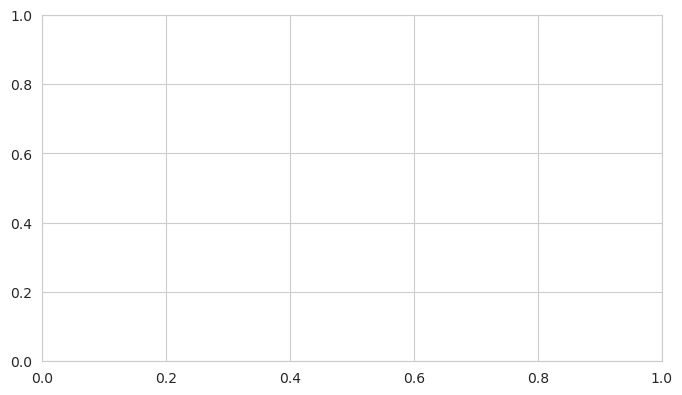

In [153]:
# In order to understand the behavior of the ADF test better conduct a small simulation to
# see the dependence of rejection/no-rejection decision on the value of the autoregressive parameter in a
# AR(1) model. To do so, run 1000 simulations in which you simulate a time-series with 100 observations
# based on the following data generating process (DGP):

# $y_t = φy_{t−1} + e_t$
# $y_0 = 0$
# $et ∼ N(0, 1)$

# Repeat the 1000 simulations for three different values of φ. Set (1) φ = 0.5, then (2) φ = 0.9, and finally
# (3) φ = 0.99. Hence, you perform 3 times 1000 simulations and in each simulation you generate a time
# series of length 100 according to the DGP with a specific φ. In each simulation draw, calculate the value
# of the ADF test statistic. Select the setting of the ADF test accordingly based on the knowledge of the
# DGP. Plot the values of the test statistics for all simulation draws in a histogram. Compare those to the
# critical values. What do you conclude regarding the performance of the ADF test based on the value of
# the autoregressive parameter in an AR(1) model?


adfss = {}

for i, phi in enumerate([0.5, 0.9, 0.99]):
    # Simulate 1000 AR(1) processes with phi
    adfs = []
    for _ in range(1000):
        e = np.random.normal(size=100)

        # Initialize y
        y = np.zeros(100)
        for t in range(1, 100):
            y[t] = phi * y[t - 1] + e[t]

        # Compute ADF test statistic
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            adf_stat = adfuller(y, regression = "n")[0]

        adfs.append(adf_stat)

    adfss[phi] = adfs

adfss = pd.DataFrame(adfss).melt(value_name="ADF test statistic", var_name="phi")


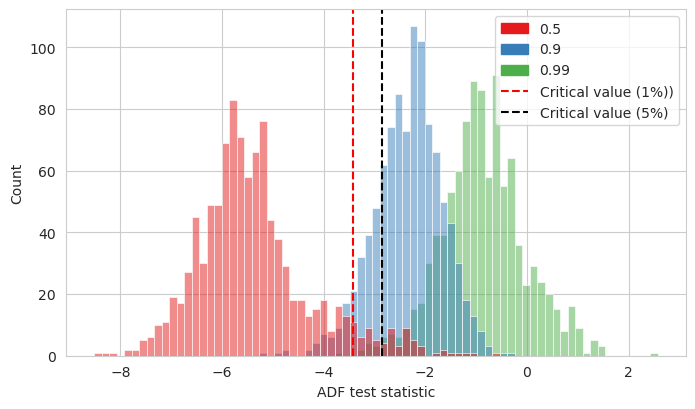

In [182]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from matplotlib.patches import Patch

# Create the seaborn plot
ax = sns.histplot(adfss, x = "ADF test statistic", hue = "phi", bins = 75, palette="Set1")

# Add the critical value lines
line1 = plt.axvline(x = -3.43, color = "red", linestyle = "--")
line2 = plt.axvline(x = -2.86, color = "black", linestyle = "--")

# Create legend entries for the lines
line1_legend = mlines.Line2D([], [], color='red', linestyle='--', label='Critical value (1%))')
line2_legend = mlines.Line2D([], [], color='black', linestyle='--', label='Critical value (5%)')

# Get the hue colors from the seaborn plot
palette = sns.color_palette("Set1", n_colors=len(adfss['phi'].unique()))

# Create legend entries for the seaborn plot
histplot_legends = [Patch(facecolor=palette[i], edgecolor=palette[i], label=label) 
                    for i, label in enumerate(adfss['phi'].unique())]

# Combine the legends
legends = histplot_legends + [line1_legend, line2_legend]

# Add the legend to the plot
plt.legend(handles=legends, loc='upper right')
plt.gcf().set_size_inches(16/2, 9/2)

plt.show()